In [1]:
import numpy as np
import gzip
import json
import pandas as pd
import pickle
import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt 

In [2]:
#####################################################
################ Forward Operations #################
#####################################################


def convolution(image, filt, bias, s=1):
    '''
    Confolves `filt` over `image` using stride `s`
    '''
    (n_f, n_c_f, f, _) = filt.shape # filter dimensions
    n_c, in_dim, _ = image.shape # image dimensions
    
    out_dim = int((in_dim - f)/s)+1 # calculate output dimensions
    
    assert n_c == n_c_f, "Dimensions of filter must match dimensions of input image"
    
    out = np.zeros((n_f,out_dim,out_dim))
    
    # convolve the filter over every part of the image, adding the bias at each step. 
    for curr_f in range(n_f):
        curr_y = out_y = 0
        while curr_y + f <= in_dim:
            curr_x = out_x = 0
            while curr_x + f <= in_dim:
                out[curr_f, out_y, out_x] = np.sum(filt[curr_f] * image[:,curr_y:curr_y+f, curr_x:curr_x+f]) + bias[curr_f]
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return out

def maxpool(image, f=2, s=2):
    '''
    Downsample `image` using kernel size `f` and stride `s`
    '''
    n_c, h_prev, w_prev = image.shape
    
    h = int((h_prev - f)/s)+1
    w = int((w_prev - f)/s)+1
    
    downsampled = np.zeros((n_c, h, w))
    for i in range(n_c):
        # slide maxpool window over each part of the image and assign the max value at each step to the output
        curr_y = out_y = 0
        while curr_y + f <= h_prev:
            curr_x = out_x = 0
            while curr_x + f <= w_prev:
                downsampled[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+f, curr_x:curr_x+f])
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
    return downsampled

def softmax(X):
    out = np.exp(X)
    return out/np.sum(out)

def categoricalCrossEntropy(probs, label):
    return -np.sum(label * np.log(probs))

In [3]:
def extract_data():
    dbfile = open('data_cnn_self.pickle', 'rb')      
    db = pickle.load(dbfile) 
    data = [i for i in db]
    data = np.array(data, dtype=np.float32)
    dbfile.close()
    return data

def extract_labels():
    labels = []
    dbfile = open('labels_cnn_self.pickle', 'rb')      
    db = pickle.load(dbfile) 
    data = [i for i in db]
    for i in data:
#         print(i)
        for j in i:
            if j == 1:
                labels.append([list(i).index(j)])
#         labels = [[list(i).index(j)+1]for j in i if j == 1] 
    labels = np.array(labels)
    dbfile.close()
    return labels

def extract_data_pred():
    dbfile = open('data_cnn_self_pred.pickle', 'rb')      
    db = pickle.load(dbfile) 
    data = [i for i in db]
    data = np.array(data, dtype=np.float32)
    dbfile.close()
    return data

def extract_labels_pred():
    labels = []
    dbfile = open('labels_cnn_self_pred.pickle', 'rb')      
    db = pickle.load(dbfile) 
    data = [i for i in db]
    for i in data:
#         print(i)
        for j in i:
            if j == 1:
                labels.append([list(i).index(j)])
#         labels = [[list(i).index(j)+1]for j in i if j == 1] 
    labels = np.array(labels)
    dbfile.close()
    return labels

def initializeFilter(size, scale = 1.0):
    '''
    To make for a smoother training process
    we initialize each filter with a mean of 0 and a standard deviation of 1.
    '''
    stddev = scale/np.sqrt(np.prod(size))
    #                       mean     stddev       
    return np.random.normal(loc = 0, scale = stddev, size = size)

def initializeWeight(size):
    return np.random.standard_normal(size=size) * 0.01

def nanargmax(arr):
    idx = np.nanargmax(arr)
    idxs = np.unravel_index(idx, arr.shape)
    return idxs
def predict(image, f1, f2, w3, w4, b1, b2, b3, b4, conv_s = 1, pool_f = 2, pool_s = 2):
    '''
    Make predictions with trained filters/weights. 
    '''
    conv1 = convolution(image, f1, b1, conv_s) # convolution operation
    conv1[conv1<=0] = 0 #relu activation
    
    conv2 = convolution(conv1, f2, b2, conv_s) # second convolution operation
    conv2[conv2<=0] = 0 # pass through ReLU non-linearity
    
    pooled = maxpool(conv2, pool_f, pool_s) # maxpooling operation
    (nf2, dim2, _) = pooled.shape
    fc = pooled.reshape((nf2 * dim2 * dim2, 1)) # flatten pooled layer
    
    z = w3.dot(fc) + b3 # first dense layer
    z[z<=0] = 0 # pass through ReLU non-linearity
    
    out = w4.dot(z) + b4 # second dense layer
    probs = softmax(out) # predict class probabilities with the softmax activation function
    
    return np.argmax(probs), np.max(probs)

In [4]:
def convolutionBackward(dconv_prev, conv_in, filt, s):
    '''
    Backpropagation through a convolutional layer. 
    '''
    (n_f, n_c, f, _) = filt.shape
    (_, orig_dim, _) = conv_in.shape
    ## initialize derivatives
    dout = np.zeros(conv_in.shape) 
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((n_f,1))
    for curr_f in range(n_f):
        # loop through all filters
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # loss gradient of filter (used to update the filter)
                dfilt[curr_f] += dconv_prev[curr_f, out_y, out_x] * conv_in[:, curr_y:curr_y+f, curr_x:curr_x+f]
                # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                dout[:, curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[curr_f, out_y, out_x] * filt[curr_f] 
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        # loss gradient of the bias
        dbias[curr_f] = np.sum(dconv_prev[curr_f])
    
    return dout, dfilt, dbias



def maxpoolBackward(dpool, orig, f, s):
    '''
    Backpropagation through a maxpooling layer. The gradients are passed through the indices of greatest value in the original maxpooling during the forward step.
    '''
    (n_c, orig_dim, _) = orig.shape
    
    dout = np.zeros(orig.shape)
    
    for curr_c in range(n_c):
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # obtain index of largest value in input for current window
                (a, b) = nanargmax(orig[curr_c, curr_y:curr_y+f, curr_x:curr_x+f])
                dout[curr_c, curr_y+a, curr_x+b] = dpool[curr_c, out_y, out_x]
                
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return dout

In [5]:
#####################################################
############### Building The Network ################
#####################################################

def conv(image, label, params, conv_s, pool_f, pool_s):
    
    [f1, f2, w3, w4, b1, b2, b3, b4] = params 
    
    ################################################
    ############## Forward Operation ###############
    ################################################
    
    conv1 = convolution(image, f1, b1, conv_s) # convolution operation
    conv1[conv1<=0] = 0 # pass through ReLU non-linearity
    
    conv2 = convolution(conv1, f2, b2, conv_s) # second convolution operation
    conv2[conv2<=0] = 0 # pass through ReLU non-linearity
    
    pooled = maxpool(conv2, pool_f, pool_s) # maxpooling operation
    
    (nf2, dim2, _) = pooled.shape
    fc = pooled.reshape((nf2 * dim2 * dim2, 1)) # flatten pooled layer
    
    z = w3.dot(fc) + b3 # first dense layer
    z[z<=0] = 0 # pass through ReLU non-linearity
    
    out = w4.dot(z) + b4 # second dense layer
    probs = softmax(out) # predict class probabilities with the softmax activation function
    
    ################################################
    #################### Loss ######################
    ################################################
    
    loss = categoricalCrossEntropy(probs, label) # categorical cross-entropy loss
        
    ################################################
    ############# Backward Operation ###############
    ################################################
    dout = probs - label # derivative of loss w.r.t. final dense layer output
    dw4 = dout.dot(z.T) # loss gradient of final dense layer weights
    db4 = np.sum(dout, axis = 1).reshape(b4.shape) # loss gradient of final dense layer biases
    
    dz = w4.T.dot(dout) # loss gradient of first dense layer outputs 
    dz[z<=0] = 0 # backpropagate through ReLU 
    dw3 = dz.dot(fc.T)
    db3 = np.sum(dz, axis = 1).reshape(b3.shape)
    
    dfc = w3.T.dot(dz) # loss gradients of fully-connected layer (pooling layer)
    dpool = dfc.reshape(pooled.shape) # reshape fully connected into dimensions of pooling layer
    
    dconv2 = maxpoolBackward(dpool, conv2, pool_f, pool_s) # backprop through the max-pooling layer(only neurons with highest activation in window get updated)
    dconv2[conv2<=0] = 0 # backpropagate through ReLU
    
    dconv1, df2, db2 = convolutionBackward(dconv2, conv1, f2, conv_s) # backpropagate previous gradient through second convolutional layer.
    dconv1[conv1<=0] = 0 # backpropagate through ReLU
    
    dimage, df1, db1 = convolutionBackward(dconv1, image, f1, conv_s) # backpropagate previous gradient through first convolutional layer.
    
    grads = [df1, df2, dw3, dw4, db1, db2, db3, db4] 
    
    return grads, loss

#####################################################
################### Optimization ####################
#####################################################

def adamGD(batch, num_classes, lr, dim, n_c, beta1, beta2, params, cost):
    '''
    update the parameters through Adam gradient descnet.
    '''
    [f1, f2, w3, w4, b1, b2, b3, b4] = params
    
    X = batch[:,0:-1] # get batch inputs
    X = X.reshape(len(batch), n_c, dim, dim)
    Y = batch[:,-1] # get batch labels
    
    cost_ = 0
    batch_size = len(batch)
    
    # initialize gradients and momentum,RMS params
    df1 = np.zeros(f1.shape)
    df2 = np.zeros(f2.shape)
    dw3 = np.zeros(w3.shape)
    dw4 = np.zeros(w4.shape)
    db1 = np.zeros(b1.shape)
    db2 = np.zeros(b2.shape)
    db3 = np.zeros(b3.shape)
    db4 = np.zeros(b4.shape)
    
    v1 = np.zeros(f1.shape)
    v2 = np.zeros(f2.shape)
    v3 = np.zeros(w3.shape)
    v4 = np.zeros(w4.shape)
    bv1 = np.zeros(b1.shape)
    bv2 = np.zeros(b2.shape)
    bv3 = np.zeros(b3.shape)
    bv4 = np.zeros(b4.shape)
    
    s1 = np.zeros(f1.shape)
    s2 = np.zeros(f2.shape)
    s3 = np.zeros(w3.shape)
    s4 = np.zeros(w4.shape)
    bs1 = np.zeros(b1.shape)
    bs2 = np.zeros(b2.shape)
    bs3 = np.zeros(b3.shape)
    bs4 = np.zeros(b4.shape)
    
    for i in range(batch_size):
        
        x = X[i]
        y = np.eye(num_classes)[int(Y[i])].reshape(num_classes, 1) # convert label to one-hot
        
        # Collect Gradients for training example
        grads, loss = conv(x, y, params, 1, 2, 2)
        [df1_, df2_, dw3_, dw4_, db1_, db2_, db3_, db4_] = grads
        
        df1+=df1_
        db1+=db1_
        df2+=df2_
        db2+=db2_
        dw3+=dw3_
        db3+=db3_
        dw4+=dw4_
        db4+=db4_

        cost_+= loss

    # Parameter Update  
        
    v1 = beta1*v1 + (1-beta1)*df1/batch_size # momentum update
    s1 = beta2*s1 + (1-beta2)*(df1/batch_size)**2 # RMSProp update
    f1 -= lr * v1/np.sqrt(s1+1e-7) # combine momentum and RMSProp to perform update with Adam
    
    bv1 = beta1*bv1 + (1-beta1)*db1/batch_size
    bs1 = beta2*bs1 + (1-beta2)*(db1/batch_size)**2
    b1 -= lr * bv1/np.sqrt(bs1+1e-7)
   
    v2 = beta1*v2 + (1-beta1)*df2/batch_size
    s2 = beta2*s2 + (1-beta2)*(df2/batch_size)**2
    f2 -= lr * v2/np.sqrt(s2+1e-7)
                       
    bv2 = beta1*bv2 + (1-beta1) * db2/batch_size
    bs2 = beta2*bs2 + (1-beta2)*(db2/batch_size)**2
    b2 -= lr * bv2/np.sqrt(bs2+1e-7)
    
    v3 = beta1*v3 + (1-beta1) * dw3/batch_size
    s3 = beta2*s3 + (1-beta2)*(dw3/batch_size)**2
    w3 -= lr * v3/np.sqrt(s3+1e-7)
    
    bv3 = beta1*bv3 + (1-beta1) * db3/batch_size
    bs3 = beta2*bs3 + (1-beta2)*(db3/batch_size)**2
    b3 -= lr * bv3/np.sqrt(bs3+1e-7)
    
    v4 = beta1*v4 + (1-beta1) * dw4/batch_size
    s4 = beta2*s4 + (1-beta2)*(dw4/batch_size)**2
    w4 -= lr * v4 / np.sqrt(s4+1e-7)
    
    bv4 = beta1*bv4 + (1-beta1)*db4/batch_size
    bs4 = beta2*bs4 + (1-beta2)*(db4/batch_size)**2
    b4 -= lr * bv4 / np.sqrt(bs4+1e-7)
    

    cost_ = cost_/batch_size
    cost.append(cost_)

    params = [f1, f2, w3, w4, b1, b2, b3, b4]
    
    return params, cost

In [6]:
#####################################################
##################### Training ######################
#####################################################
def train(num_classes = 4, lr = 0.01, beta1 = 0.95, beta2 = 0.99, img_dim = 28, img_depth = 1, f = 5, num_filt1 = 8, num_filt2 = 8, batch_size = 32, num_epochs = 2, save_path = 'params.pkl'): 
#     m =10000
    X = extract_data()
    #     print(X.shape)
    y_dash = extract_labels()
    #     print(y_dash)
    # Normalize the data
    X-= int(np.mean(X)) # subtract mean
    X/= int(np.std(X)) # divide by standard deviation
    #     print(X.shape)
    #     print(y_dash[:10])
    train_data = np.hstack((X,y_dash))
    #     print(test_data.shape)
    np.random.shuffle(train_data)

    ## Initializing all the parameters
    f1, f2, w3, w4 = (num_filt1 ,img_depth,f,f), (num_filt2 ,num_filt1,f,f), (128,800), (4, 128)
    f1 = initializeFilter(f1)
    f2 = initializeFilter(f2)
    w3 = initializeWeight(w3)
    w4 = initializeWeight(w4)

    b1 = np.zeros((f1.shape[0],1))
    b2 = np.zeros((f2.shape[0],1))
    b3 = np.zeros((w3.shape[0],1))
    b4 = np.zeros((w4.shape[0],1))

    params = [f1, f2, w3, w4, b1, b2, b3, b4]

    cost = []
    
    print("LR:"+str(lr)+", Batch Size:"+str(batch_size))

    for epoch in range(num_epochs):
        np.random.shuffle(train_data)
        batches = [train_data[k:k + batch_size] for k in range(0, train_data.shape[0], batch_size)]

        t = tqdm(batches)
        for x,batch in enumerate(t):
            params, cost = adamGD(batch, num_classes, lr, img_dim, img_depth, beta1, beta2, params, cost)
            t.set_description("Cost: %.2f" % (cost[-1]))
            
    to_save = [params, cost]
    
    with open(save_path, 'wb') as file:
        pickle.dump(to_save, file)
        
    return cost

LR:0.01, Batch Size:32


Cost: 0.92: 100%|████████████████████████████████████████████████████████████████████| 219/219 [24:26<00:00,  6.69s/it]


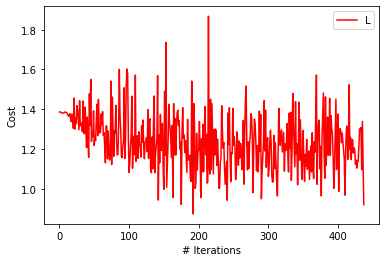

In [7]:
save_path = "params.pkl"
cost = train()

params, cost = pickle.load(open(save_path, 'rb'))
[f1, f2, w3, w4, b1, b2, b3, b4] = params

# Plot cost 
plt.plot(cost, 'r')
plt.xlabel('# Iterations')
plt.ylabel('Cost')
plt.legend('Loss', loc='upper right')
plt.show()




Computing accuracy over test set:




  0%|                                                                                         | 0/1659 [00:00<?, ?it/s]

  0%|                                                                                 | 2/1659 [00:00<02:25, 11.41it/s]

  0%|▏                                                                                | 3/1659 [00:00<02:37, 10.50it/s]

  0%|▏                                                                                | 4/1659 [00:00<02:41, 10.23it/s]

  0%|▏                                                                                | 5/1659 [00:00<02:43, 10.10it/s]

  0%|▎                                                                                | 6/1659 [00:00<02:45,  9.99it/s]

  0%|▎                                                                                | 7/1659 [00:00<02:48,  9.80it/s]

  0%|▍                                                                                | 8/1659 [00:00<02:51,  9.64it/s]

  1%|▍                        

Overall Accuracy: 12.66


ValueError: shape mismatch: objects cannot be broadcast to a single shape

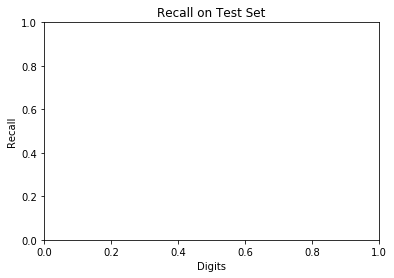

In [10]:
# Get test data
X = extract_data_pred()
y_dash = extract_labels_pred()
# Normalize the data
X-= int(np.mean(X)) # subtract mean
X/= int(np.std(X)) # divide by standard deviation
test_data = np.hstack((X,y_dash))
# print(test_data)


X = test_data[:,0:-1]
X = X.reshape(len(test_data), 1, 28, 28)
y = test_data[:,-1]

corr = 0
digit_count = [0 for i in range(4)]
digit_correct = [0 for i in range(4)]

print()
print("Computing accuracy over test set:")

for i in tqdm(range(len(X))):
    x = X[i]
    pred, prob = predict(x, f1, f2, w3, w4, b1, b2, b3, b4)
    digit_count[int(y[i])]+=1
    if pred==y[i]:
        corr+=1
        digit_correct[pred]+=1

print("Overall Accuracy: %.2f" % (float(corr/len(test_data)*100)))
x = np.arange(3)
digit_recall = [x/y for x,y in zip(digit_correct, digit_count)]
plt.xlabel('Digits')
plt.ylabel('Recall')
plt.title("Recall on Test Set")
plt.bar(x,digit_recall)
plt.show()